# Q&A Generative Chatbot

In [1]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-11-04 18:25:01.829717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Percorsi ai file JSON
annotations_train_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Annotations/v2_mscoco_train2014_annotations.json'
annotations_val_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Annotations/v2_mscoco_val2014_annotations.json'
questions_train_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Questions/v2_OpenEnded_mscoco_train2014_questions.json'
questions_val_path = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Questions/v2_OpenEnded_mscoco_val2014_questions.json'
images_train_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
images_val_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'

In [3]:
# Carica i file di annotazioni e domande
with open(annotations_train_path, 'r') as f:
    annotations_train = json.load(f)

with open(annotations_val_path, 'r') as f:
    annotations_val = json.load(f)

with open(questions_train_path, 'r') as f:
    questions_train = json.load(f)

with open(questions_val_path, 'r') as f:
    questions_val = json.load(f)

I file JSON delle annotazioni e delle domande vengono caricati in variabili. 

create_df: Combina annotazioni e domande in un DataFrame, utilizzando question_id per unire domande e risposte. Crea inoltre il percorso dell’immagine usando image_id. Ogni riga contiene image_id, question_id, question, answer e image_path per accedere facilmente all'immagine.

In [4]:
# Crea DataFrame per le annotazioni e le domande
def create_df(annotations, questions):
    # Crea un dizionario delle domande con `question_id` come chiave
    questions_dict = {q['question_id']: q['question'] for q in questions['questions']}
    
    # Costruisci una lista di dizionari con tutte le informazioni necessarie
    data = []
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        question_id = ann['question_id']
        question = questions_dict.get(question_id, "No question found")
        answer = ann['multiple_choice_answer']
        
        # Aggiungi l'informazione al dataset
        data.append({
            'image_id': image_id,
            'question_id': question_id,
            'question': question,
            'answer': answer,
            'image_path': os.path.join(images_train_dir if 'train' in annotations['info']['description'] else images_val_dir, f"COCO_train2014_{str(image_id).zfill(12)}.jpg")
        })
    
    return pd.DataFrame(data)

In [5]:
# Crea i DataFrame per il training e la validation
train_df = create_df(annotations_train, questions_train)
val_df = create_df(annotations_val, questions_val)

# Visualizza le prime righe del training DataFrame per confermare il caricamento
print("Training DataFrame Head:")
print(train_df.head())

# Visualizza le prime righe del validation DataFrame per confermare il caricamento
print("\nValidation DataFrame Head:")
print(val_df.head())

Training DataFrame Head:
   image_id  question_id                                     question  \
0    458752    458752000    What is this photo taken looking through?   
1    458752    458752001           What position is this man playing?   
2    458752    458752002             What color is the players shirt?   
3    458752    458752003  Is this man a professional baseball player?   
4    262146    262146000                      What color is the snow?   

    answer                                         image_path  
0      net  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
1  pitcher  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
2   orange  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
3      yes  /home/pierluigi/Documents/datasets/Chatbot/VQA...  
4    white  /home/pierluigi/Documents/datasets/Chatbot/VQA...  

Validation DataFrame Head:
   image_id  question_id                                      question  \
0    262148    262148000                          

 Ora ogni riga contiene:

- image_id: per identificare l'immagine.
- question_id: per tenere traccia delle domande.
- question: la domanda completa.
- answer: la risposta principale alla domanda.
- image_path: il percorso dell’immagine associata, che potrai caricare per l’addestramento.

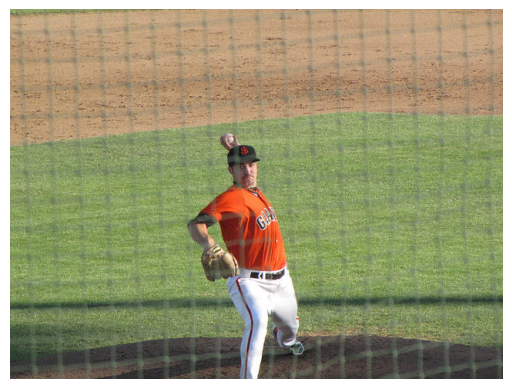

Image ID: 458752
Questions and Answers:
Q: What is this photo taken looking through?
A: net
Q: What position is this man playing?
A: pitcher
Q: What color is the players shirt?
A: orange
Q: Is this man a professional baseball player?
A: yes


In [6]:
# Estrai la prima riga del DataFrame
first_row = train_df.iloc[0]
image_id = first_row['image_id']

# Determina la cartella corretta in base al set di addestramento o validazione
if "train" in first_row['image_path']:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'

# Costruisci il percorso corretto per l'immagine
image_path = os.path.join(image_dir, f"COCO_train2014_{str(image_id).zfill(12)}.jpg")

# Raccogli tutte le domande e risposte associate all'image_id
questions_answers = train_df[train_df['image_id'] == image_id][['question', 'answer']]

# Carica e mostra l'immagine
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Rimuovi gli assi per una visualizzazione più chiara
    plt.show()

    # Stampa le domande e risposte associate
    print(f"Image ID: {image_id}")
    print("Questions and Answers:")
    for idx, row in questions_answers.iterrows():
        print(f"Q: {row['question']}")
        print(f"A: {row['answer']}")

except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

## Data Preprocessing

- Tokenizzazione: Dividiamo le domande e risposte in singoli token (parole) e rimuoviamo eventuali simboli o caratteri speciali.
- Conversione in sequenze numeriche: Assegniamo un indice numerico a ciascun token, in modo che il modello possa elaborare le sequenze di parole.
- Padding delle sequenze: Per avere lunghezze uniformi, applichiamo il padding alle sequenze, rendendole tutte della stessa lunghezza.
- Embedding: Possiamo utilizzare un embedding pre-addestrato (come GloVe o Word2Vec) o allenare un embedding direttamente sul nostro dataset.

In [7]:
# Estrai domande e risposte dai DataFrame di train e validation
train_questions = train_df['question'].values
train_answers = train_df['answer'].values
val_questions = val_df['question'].values
val_answers = val_df['answer'].values

# Imposta i parametri per la tokenizzazione e la lunghezza delle sequenze
vocab_size = 5000  # Dimensione del vocabolario
max_length = 20    # Lunghezza massima per le domande
oov_token = "<OOV>"

In [8]:
# Inizializza il tokenizzatore e adatta sui testi delle domande
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_questions)

# Converti domande e risposte in sequenze numeriche e applica il padding
train_questions_seq = tokenizer.texts_to_sequences(train_questions)
train_questions_padded = pad_sequences(train_questions_seq, maxlen=max_length, padding='post', truncating='post')

val_questions_seq = tokenizer.texts_to_sequences(val_questions)
val_questions_padded = pad_sequences(val_questions_seq, maxlen=max_length, padding='post', truncating='post')

# Tokenizza le risposte (opzionale per risposte più lunghe)
tokenizer.fit_on_texts(train_answers)
train_answers_seq = tokenizer.texts_to_sequences(train_answers)
train_answers_padded = pad_sequences(train_answers_seq, maxlen=max_length, padding='post', truncating='post')

val_answers_seq = tokenizer.texts_to_sequences(val_answers)
val_answers_padded = pad_sequences(val_answers_seq, maxlen=max_length, padding='post', truncating='post')

# Verifica del risultato
print("Sample Question (tokenized and padded):", train_questions_padded[0])
print("Sample Answer (tokenized and padded):", train_answers_padded[0])

Sample Question (tokenized and padded): [  4   3   6  28  71  99 470   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Sample Answer (tokenized and padded): [1166    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


L’output indica che il pre-processing ha funzionato correttamente. Le domande e le risposte sono state convertite in sequenze di indici numerici e quindi riempite con zeri (padding) fino alla lunghezza massima (max_length).

## Embedding Layer

Traduciamo i token numerici delle domande e risposte in vettori densi.

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [37]:
# Parametri
embedding_dim = 64  # Dimensione dell'embedding
rnn_units = 128     # Unità per l'LSTM

# Input per le domande
question_input = Input(shape=(max_length,), name='question_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(question_input)
rnn_layer = LSTM(rnn_units, return_sequences=False)(embedding_layer)

# Strato denso finale per generare la risposta
output_layer = Dense(vocab_size, activation='softmax')(rnn_layer)

# Modello finale
model = Model(inputs=question_input, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizza il sommario del modello
model.summary()

/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ question_input (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5000)           │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,816 (4.06 MB)

 Trainable params: 1,063,816 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

## Training

La funzione di perdita sparse_categorical_crossentropy si aspetta che le etichette (le risposte) abbiano una dimensione in meno rispetto all'output del modello. Attualmente, le risposte sono rappresentate come sequenze con padding di dimensione (None, 20), ma dovrebbero invece essere un singolo indice per ciascuna risposta.

Poiché stiamo utilizzando sparse_categorical_crossentropy, dobbiamo rappresentare ogni risposta come un singolo indice (cioè, la parola target della risposta) piuttosto che come una sequenza intera. In altre parole, il target (risposta) dovrebbe avere la forma (batch_size,), con ciascun valore che rappresenta l'indice di una parola.

Per risolvere il problema, possiamo:

1. Estrarre la parola principale della risposta come un singolo indice numerico.
2. Eliminare il padding dalle risposte e mantenerle come un singolo indice.

In alcuni casi train_answers_seq potrebbe contenere sequenze vuote. Questo può succedere se alcune risposte non sono state correttamente tokenizzate o sono state filtrate.
- Controllo della lunghezza: Per ogni answer in train_answers_seq e val_answers_seq, verifica se contiene almeno un elemento. Se sì, prende il primo elemento; altrimenti, imposta il valore a 0.

In [11]:
# Rimuove il padding e prende il primo token come risposta principale, se presente
train_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in train_answers_seq])
val_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in val_answers_seq])

# Parametri di addestramento
batch_size = 64  # Numero di campioni per batch
epochs = 10      # Numero di epoche di addestramento

# Esegui l'addestramento con le risposte aggiornate
history = model.fit(
    train_questions_padded,         # Domande di training
    train_answers_single,           # Risposte singole di training
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_questions_padded, val_answers_single)  # Dati di validazione
)

Epoch 1/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 461s 66ms/step - accuracy: 0.2285 - loss: 4.1149 - val_accuracy: 0.2993 - val_loss: 2.7975
Epoch 2/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 514s 74ms/step - accuracy: 0.3095 - loss: 2.6833 - val_accuracy: 0.3313 - val_loss: 2.5332
Epoch 3/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 535s 77ms/step - accuracy: 0.3341 - loss: 2.4322 - val_accuracy: 0.3414 - val_loss: 2.4256
Epoch 4/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 541s 78ms/step - accuracy: 0.3480 - loss: 2.2971 - val_accuracy: 0.3473 - val_loss: 2.3668
Epoch 5/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 663s 96ms/step - accuracy: 0.3568 - loss: 2.2069 - val_accuracy: 0.3577 - val_loss: 2.3374
Epoch 6/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 685s 99ms/step - accuracy: 0.3646 - loss: 2.1371 - val_accuracy: 0.3568 - val_loss: 2.3196
Epoch 7/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 409s 59ms/step - accuracy: 0.3731 - loss: 2.0812 - val_accuracy: 0.3588 - val_loss: 2.3149
Epoch 8/10
6934/6934 ━━━━━━━━━━━━━━━━━━━━ 396s 57ms/step - accuracy: 

Le ragioni per cui l'accuratezza è ancora bassa possono essere molteplici, specialmente in un task di Visual Question Answering (VQA), che è complesso di per sé. Ecco alcune possibili cause per la tua attuale accuratezza:

Limiti del Modello (LSTM):

Un modello LSTM può essere limitato nel catturare la complessità delle interazioni tra testo e immagini in un task VQA. Le LSTM non gestiscono al meglio contesti complessi e non sono progettate specificamente per comprendere informazioni visive.
Mancanza di Feature Visive:

In questo caso, stiamo usando solo l’input di testo. Senza un'integrazione con feature estratte dalle immagini (ad esempio, attraverso una CNN pre-addestrata come ResNet), il modello potrebbe faticare a rispondere accuratamente a domande visive.
Dimensione del Vocabolario e Embedding:

L’attuale dimensione del vocabolario e del layer di embedding potrebbe essere limitante per la varietà delle domande e risposte nel dataset VQA, che spesso include termini molto specifici. Un embedding più grande o un vocabolario più ampio potrebbe aiutare.
Dati di Addestramento:

Anche se hai un set di dati ampio, il task di VQA è difficile e richiede spesso un numero elevato di epoche per migliorare sensibilmente l'accuratezza.
Struttura della Rete:

L’architettura corrente è semplice: un singolo livello LSTM con un’uscita densa. Una struttura più complessa (ad esempio, più layer LSTM o un Transformer) potrebbe modellare meglio la struttura delle domande.

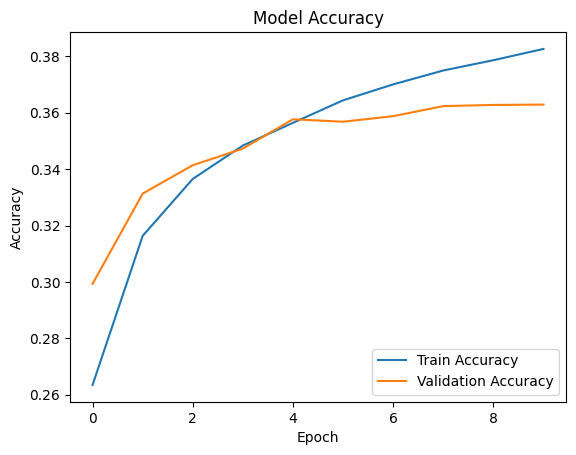

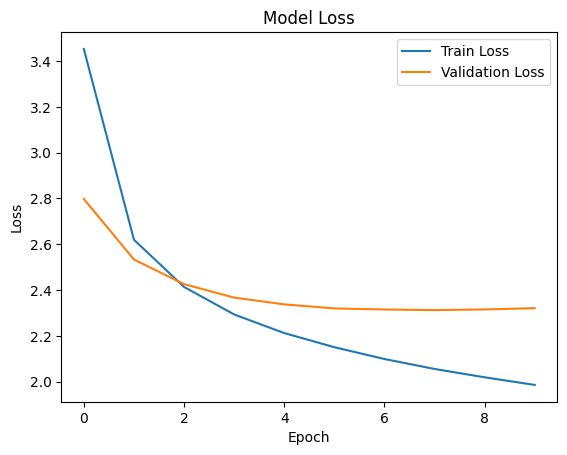

In [12]:
# Grafico dell'accuratezza
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Grafico della perdita
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()


## Model Testing

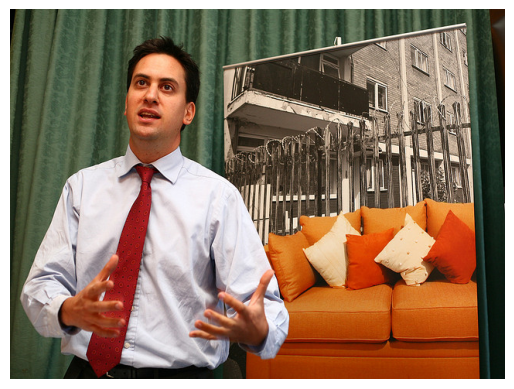

Question: Is this man wearing a hat?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Predicted Answer: no
Correct Answer: no


In [ ]:
# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict(test_question.reshape(1, -1))
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")


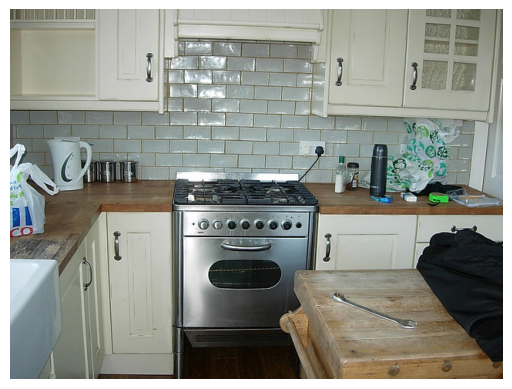

Question: What room is this?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Answer: kitchen
Correct Answer: kitchen


In [16]:
# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict(test_question.reshape(1, -1))
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")


## CRNN Model

il nostro modello attuale è basato solo sull'input di testo per rispondere alla domanda, senza una componente di visione (CNN) che possa estrarre feature visive direttamente dall'immagine.

Quindi, attualmente:

Le risposte del modello si basano solo sull'input testuale. Senza una CNN che analizza attivamente l'immagine, il modello risponde in base a quanto ha appreso nel dataset VQA sulle associazioni tra domande di testo e risposte, ma non sta "vedendo" l'immagine.
Per renderlo effettivamente in grado di riconoscere gli oggetti nella foto, dovremmo integrare un componente visivo (ad esempio, una CNN) per estrarre le feature visive dall'immagine e passare queste informazioni al modello insieme alla domanda.

Per aggiungere una componente visiva, **implementeremo una CNN pre-addestrata (come ResNet) per estrarre le feature dalle immagini**. Successivamente, **queste feature saranno combinate con la rappresentazione testuale della domanda attraverso la LSTM**. 

### Struttura Modello

1. Feature Visive: Una CNN (es. ResNet) estrae le caratteristiche visive dell’immagine.
2. Feature Testuali: La LSTM processa la domanda.
3. Concatenazione delle Feature: Uniamo le feature visive e testuali in un unico vettore.
4. Output: Un layer finale produce la risposta.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [13]:
# Caricamento della CNN pre-addestrata
embedding_dim = 64  # Dimensione dell'embedding
rnn_units = 128     # Unità per l'LSTM

cnn_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_output = GlobalAveragePooling2D()(cnn_base.output)  # Riduzione dimensionale per le feature visive

# Input per la domanda (LSTM)
question_input = Input(shape=(max_length,), name='question_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(question_input)
rnn_layer = LSTM(rnn_units, return_sequences=False)(embedding_layer)

# Concatenazione delle feature visive e testuali
merged = Concatenate()([cnn_output, rnn_layer])

# Layer finale per generare la risposta
output_layer = Dense(vocab_size, activation='softmax')(merged)

# Costruzione del modello
model = Model(inputs=[cnn_base.input, question_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizza il sommario del modello
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,891,528 (133.10 MB)

 Trainable params: 34,838,408 (132.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

Per addestrare il modello, ci assicuriamo di:

- Ridimensionare le immagini a 224x224 pixel (input per ResNet).
- Convertire le domande in sequenze tokenizzate e con padding.

Dividere il pre-processing delle immagini e l’addestramento in due fasi separate può aiutare a ridurre il carico e a evitare di sovraccaricare il sistema. Procediamo in questo modo:

- Pre-processing delle Immagini: Processiamo metà del training set e del validation set separatamente, salvando le feature visive preprocessate in array.
- Addestramento: In un secondo blocco, carichiamo gli array preprocessati e li usiamo per addestrare il modello.

Limitiamo il dataset a 10.000 immagini sia per il training set che per il validation set.

#### Preprocessing Immagini

In [14]:
# Funzione di pre-processing per ResNet
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

In [15]:
# Pre-processing per 1000 immagini di training
train_sample_size = 1000  # Limite a 1000 immagini
train_images = []
images_processed = 0
train_image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'

for i, path in enumerate(train_df['image_path'][:train_sample_size]):
    full_path = os.path.join(train_image_dir, os.path.basename(path))
    try:
        train_images.append(preprocess_image(full_path))
        images_processed += 1
        if images_processed % 500 == 0:
            print(f"Caricate {images_processed} immagini per il training")
    except FileNotFoundError:
        print(f"Image not found at path: {full_path}, saltata.")

train_images = np.array(train_images)
np.save('train_images_preprocessed_1k.npy', train_images)  # Salva le feature preprocessate
print("Caricamento delle immagini di training completato e salvato.")

Caricate 500 immagini per il training
Caricate 1000 immagini per il training
Caricamento delle immagini di training completato e salvato.


In [16]:
# Pre-processing per 1000 immagini di validazione, forzando il prefisso COCO_val2014
val_sample_size = 1000  # Limite a 1000 immagini
val_images = []
images_processed = 0
val_image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'

for i, path in enumerate(val_df['image_path'][:val_sample_size]):
    # Forza il prefisso COCO_val2014 per tutte le immagini di validazione
    image_filename = os.path.basename(path).replace("COCO_train2014", "COCO_val2014")
    full_path = os.path.join(val_image_dir, image_filename)
    try:
        val_images.append(preprocess_image(full_path))
        images_processed += 1
        if images_processed % 500 == 0:
            print(f"Caricate {images_processed} immagini per la validazione")
    except FileNotFoundError:
        print(f"Image not found at path: {full_path}, saltata.")

val_images = np.array(val_images)
np.save('val_images_preprocessed_1k.npy', val_images)  # Salva le feature preprocessate
print("Caricamento delle immagini di validazione completato e salvato.")


Caricate 500 immagini per la validazione
Caricate 1000 immagini per la validazione
Caricamento delle immagini di validazione completato e salvato.


#### Training Modello

In [20]:
import time

# Carica le feature preprocessate per il training e la validazione
start_time = time.time()
train_images = np.load('train_images_preprocessed_1k.npy')
print(f"Caricamento train_images completato in {time.time() - start_time:.2f} secondi")

start_time = time.time()
val_images = np.load('val_images_preprocessed_1k.npy')
print(f"Caricamento val_images completato in {time.time() - start_time:.2f} secondi")

# Limita le domande e risposte a 1000 campioni
train_sample_size = 1000
val_sample_size = 1000

batch_size = 32 
epochs = 10

train_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in train_answers_seq])
val_answers_single = np.array([answer[0] if len(answer) > 0 else 0 for answer in val_answers_seq])

train_questions_reduced = train_questions_padded[:train_sample_size]
train_answers_reduced = train_answers_single[:train_sample_size]

val_questions_reduced = val_questions_padded[:val_sample_size]
val_answers_reduced = val_answers_single[:val_sample_size]

# Avvia l'addestramento
history = model.fit(
    [train_images, train_questions_reduced],
    train_answers_reduced,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_images, val_questions_reduced], val_answers_reduced),
    verbose=1
)


Caricamento train_images completato in 1.19 secondi
Caricamento val_images completato in 1.02 secondi
Epoch 1/10


2024-11-04 18:36:31.232050: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602112000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1878 - loss: 4.2011 

2024-11-04 18:44:33.633078: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602112000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 570s 18s/step - accuracy: 0.1880 - loss: 4.1985 - val_accuracy: 0.0080 - val_loss: 196.6153
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 569s 18s/step - accuracy: 0.2696 - loss: 3.2571 - val_accuracy: 0.0930 - val_loss: 49.3412
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 566s 18s/step - accuracy: 0.3392 - loss: 2.5290 - val_accuracy: 0.2410 - val_loss: 7.5830
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 568s 18s/step - accuracy: 0.3766 - loss: 2.0573 - val_accuracy: 0.1940 - val_loss: 6.0860
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 570s 18s/step - accuracy: 0.4382 - loss: 1.8179 - val_accuracy: 0.2240 - val_loss: 17.0403
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 624s 18s/step - accuracy: 0.4243 - loss: 1.7454 - val_accuracy: 0.2080 - val_loss: 6.4277
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 569s 18s/step - accuracy: 0.4544 - loss: 1.6310 - val_accuracy: 0.2390 - val_loss: 5.6947
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 599s 19s/step - accuracy: 0.4901 - loss: 1.4493 - val_accuracy: 0.2310 - 

## Model Testing

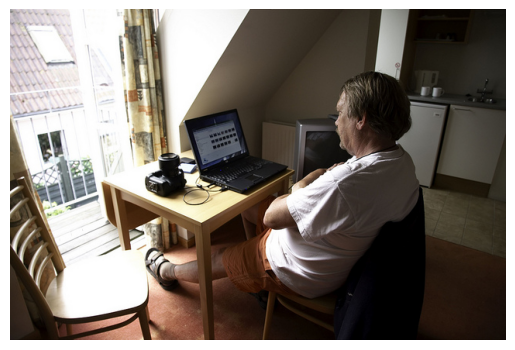

Question: Could that be a digital camera?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted Answer: yes
Correct Answer: yes


In [38]:
# Funzione per pre-processare una nuova immagine per il modello
def preprocess_new_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array


# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

# Determina la directory corretta e costruisce il percorso dell'immagine
if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Pre-processa l'immagine per il modello
preprocessed_image = preprocess_new_image(image_path).reshape((1, 224, 224, 3))

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict([preprocessed_image, test_question.reshape(1, -1)])
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")


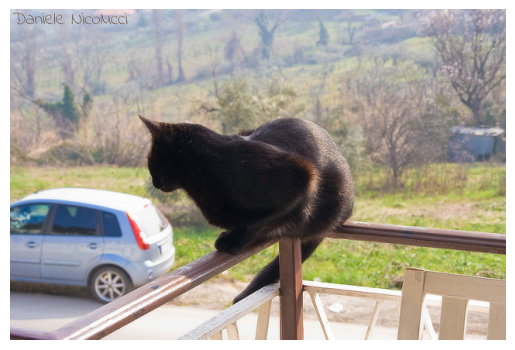

Question: Is this animal domesticated?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted Answer: yes
Correct Answer: yes


In [ ]:
# Scegli una domanda casuale dal set di validazione
random_index = random.randint(0, len(val_questions_padded) - 1)
test_question = val_questions_padded[random_index]
test_image_id = val_df.iloc[random_index]['image_id']
test_image_path = val_df.iloc[random_index]['image_path']

# Determina la directory corretta e costruisce il percorso dell'immagine
if "val2014" in test_image_path:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/val2014/'
else:
    image_dir = '/home/pierluigi/Documents/datasets/Chatbot/VQA Input Images/train2014/'
image_path = f"{image_dir}COCO_val2014_{str(test_image_id).zfill(12)}.jpg"

# Visualizza l'immagine associata
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found at path: {image_path}")

# Pre-processa l'immagine per il modello
preprocessed_image = preprocess_new_image(image_path).reshape((1, 224, 224, 3))

# Recupera la domanda originale e stampa la risposta predetta
original_question = val_df.iloc[random_index]['question']
print(f"Question: {original_question}")

# Prevedi la risposta
predicted_answer = model.predict([preprocessed_image, test_question.reshape(1, -1)])
predicted_index = predicted_answer.argmax()  # Trova l'indice della parola con probabilità più alta

# Recupera la parola dalla tokenizzazione inversa
predicted_word = tokenizer.index_word.get(predicted_index, "Unknown")
print(f"Predicted Answer: {predicted_word}")

# Confronta con la risposta corretta
correct_answer = val_df.iloc[random_index]['answer']
print(f"Correct Answer: {correct_answer}")


## Saving the Model

In [34]:
# Salva il modello in formato .h5
model.save('vqa_model.h5')
print("Modello salvato come vqa_model.h5")

Modello salvato come vqa_model.h5


In [ ]:
# from tensorflow.keras.models import load_model
# import numpy as np

# # Carica il modello salvato
# model = load_model('vqa_model.h5')  # Usa 'vqa_model' se hai usato il formato SavedModel

# # Ora puoi usare `model.predict()` per fare previsioni
